In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [6]:
# tuning the model:

block_size = 3  # context length: how many characters do we take to predict the next one?
n_embd = 10  # number of dimensions in embedding
layer_1_input = block_size * n_embd
n_hidden = 200
batch_size = 32
max_steps = 200000

In [7]:
# building the dataset

def build_dataset(words):
    X, Y = [], []  # X is the array of the input characters, Y is the output for those input characters
    
    for w in words:
        
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', ch)
            context = context[1:] + [ix]  # crop and append for next character's context
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((layer_1_input, n_hidden), generator=g) * ((5/3) / (layer_1_input**0.5))  
#b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0  # biases can be 0 as well at initialization, 0.01 can help with some entropy and optimization

bngain = torch.ones((1, n_hidden))  # allows the network to scale each normalized feature
bnbias = torch.zeros((1, n_hidden))  # allows the network to shift each normalized feature

# this is so we don't have to separately calculate these after training
bnmean_running = torch.zeros((1, n_hidden))  # at initialization, because we've initialized them to unit gaussian, mean will be roughly 0 and S.D. 1
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)  # number of parameters in total

12097

In [15]:
lri = []
lossi = []
stepi = []

In [19]:
for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y
    
    # forward pass
    emb = C[Xb]  # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1  # + b1  # hidden layer pre-activation
    # BatchNorm layer
    # -----------------------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = (bngain * (hpreact - bnmeani) / bnstdi) + bnbias  # batch normalization layer

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -----------------------------------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer 
    loss = F.cross_entropy(logits, Yb)  # loss function 
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())

    #break

      0/ 200000:3.2736
  10000/ 200000:2.3246
  20000/ 200000:2.0229
  30000/ 200000:2.0292
  40000/ 200000:2.0587
  50000/ 200000:2.8989
  60000/ 200000:2.1025
  70000/ 200000:2.8280
  80000/ 200000:2.5755
  90000/ 200000:2.2545
 100000/ 200000:2.0482
 110000/ 200000:1.8211
 120000/ 200000:1.8397
 130000/ 200000:2.4059
 140000/ 200000:2.4866
 150000/ 200000:2.4214
 160000/ 200000:2.1187
 170000/ 200000:2.1708
 180000/ 200000:2.1542
 190000/ 200000:2.0988


In [10]:
plt.plot(lossi)

In [22]:
#this decorator disables gradient tracking
@torch.no_grad()  # pytorch will not keep track of gradients of tensors here, as they are not needed. To improve efficiency
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    # hpreact = (bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)) + bnbias  # batch normalization layer
    hpreact = (bngain * (hpreact - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0673139095306396
val 2.105574131011963


In [23]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size  # initialize with all '...'
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print generated word

briahgmnazzierstel.
fhal.
qetvangendra.
zasderidgmlillshi.
jedrikelssandvannellyssllyaphn.
shdumrithghnestin.
jewtdvi.
xibuscfsubferndersymphi.
qhiyrahshvykoldnihannaviyahsufizajahkirrentirbbisvekostep.
qwilfeyroshbh.
zprixabumushmarhmirosbishaidfflystlwaldarikthrishthzighikassmitgftrvissivishmellakethrishldahmaudkeshdekitya.
blvardtaiweddie.
virlq.
saadenaysophlrystta.
ziyah.
vontet.
judnylissaphrygnovevt.
jshmptrykshmphithlisandvekessamariopsi.
trielt.
sep.


In [49]:
# SUMMARY and PyTorch-ifying the code ----------------------------------------

In [79]:
# Let's train a deeper network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):  # __call__ allows an instance of a class to be called and used as a function by defining the function body
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True  # this is for if we are training or using it on our dev set for evaluation or testing
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)  # this is like bngain
        self.beta = torch.zeros(dim)  # like bnbias
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:  # during inference, we are using the running mean and running variance
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10  # dimensionality of the character embedding vectors
n_hidden = 100  # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),  # its okay to place batchnorm after the last layer as well
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weight *= 0.1  ---> this was for the without batchnorm version
    layers[-1].gamma *= 0.1
    # all other layers: apply gain. this step is for when we are not using batchnorm
    for layer in layers[:-1]:
        if isinstance(layer, Linear): 
            layer.weight *= 5/3  # this gain is necessary to fight the squashing effect of all the tanhs which would eventually squash everything down to 0 if not for this

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

47551


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean 0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean 0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

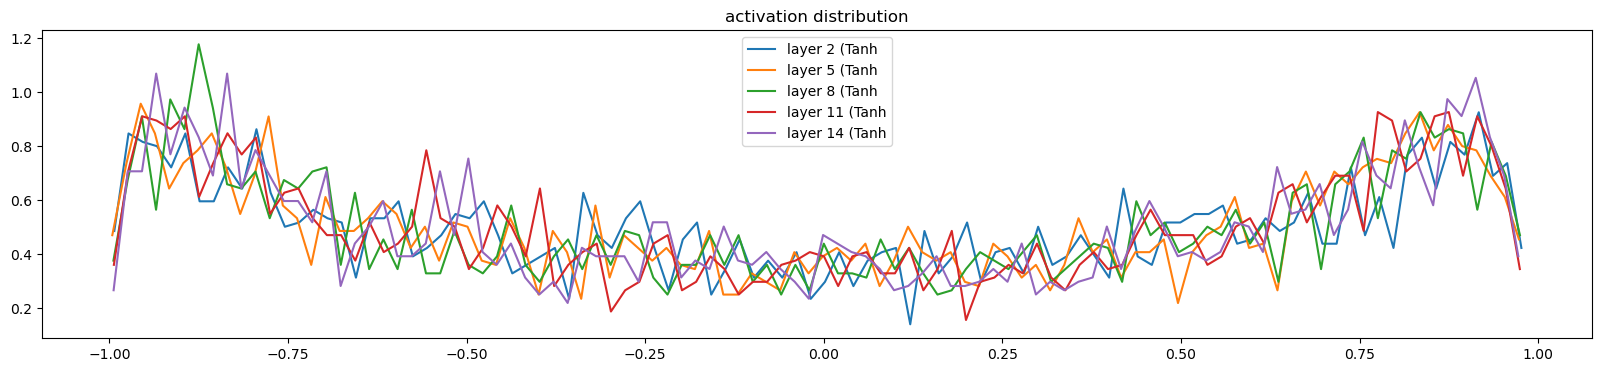

In [81]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()> 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True) 
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (Tanh): mean -0.00, std 0.00
layer 5 (Tanh): mean -0.00, std 0.00
layer 8 (Tanh): mean 0.00, std 0.00
layer 11 (Tanh): mean 0.00, std 0.00
layer 14 (Tanh): mean 0.00, std 0.00


Text(0.5, 1.0, 'gradient distribution')

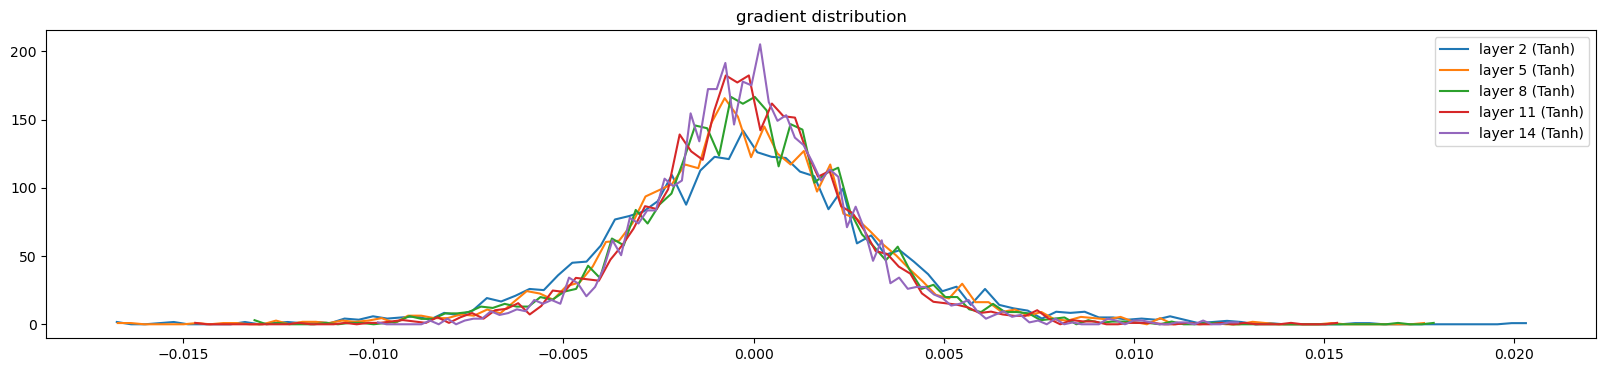

In [82]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad  # Assuming you want to plot the gradient
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():.2f}, std {t.std():.2f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight (27, 10) | mean 0.000000 | std 1.019887e-02 | grad:data ratio 5.411333e-09
weight (30, 100) | mean 0.000092 | std 8.238437e-03 | grad:data ratio 1.119470e-02
weight (100, 100) | mean 0.000031 | std 7.318116e-03 | grad:data ratio 4.171290e-03
weight (100, 100) | mean -0.000019 | std 6.662026e-03 | grad:data ratio -2.782082e-03
weight (100, 100) | mean -0.000019 | std 5.821517e-03 | grad:data ratio -3.289132e-03
weight (100, 100) | mean 0.000053 | std 5.445298e-03 | grad:data ratio 9.665144e-03
weight (100, 27) | mean -0.000165 | std 1.046845e-02 | grad:data ratio -1.574106e-02


Text(0.5, 1.0, 'Weights Gradient Distribution')

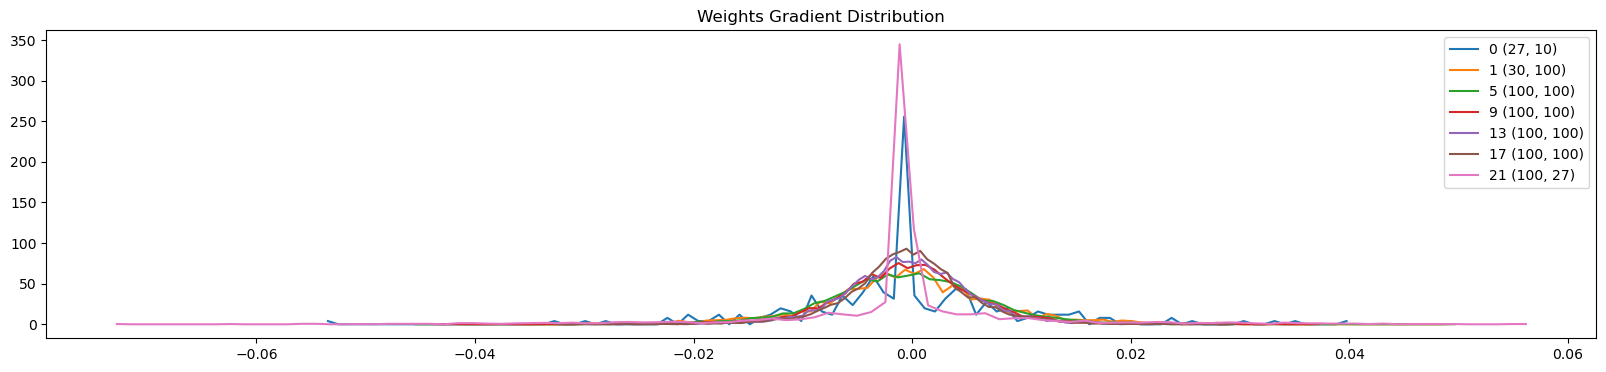

In [83]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:  # Check if the parameter is a weight matrix
        print(f'weight {tuple(p.shape)} | mean {t.mean():.6f} | std {t.std():.6e} | grad:data ratio {t.mean() / (t.std() + 1e-10):.6e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution')

Text(0.5, 1.0, 'Parameter Ratios Over Iterations')

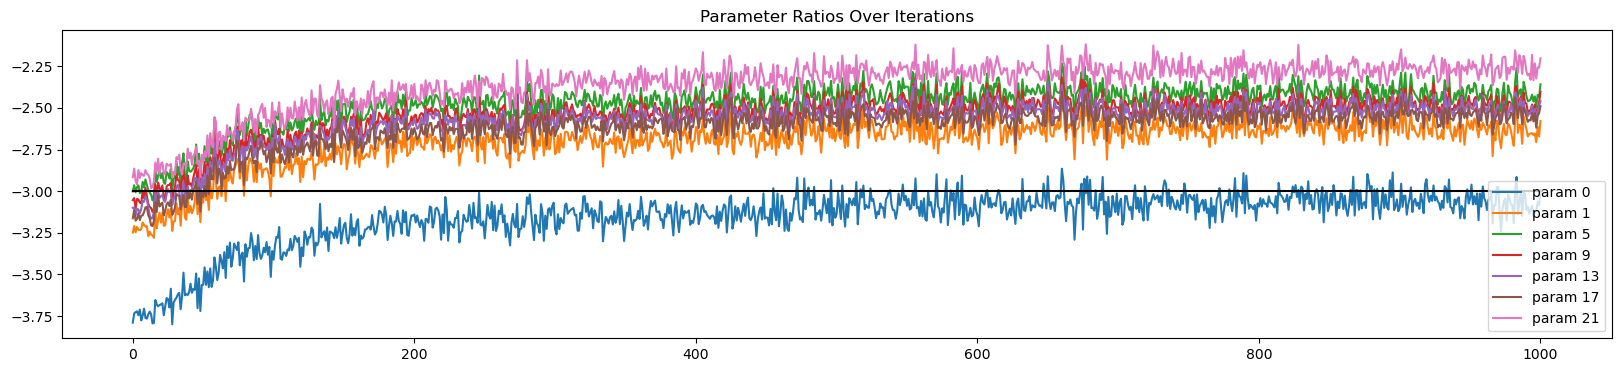

In [84]:
plt.figure(figsize=(20, 4)) 
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:  # Check if the parameter is a 2-dimensional tensor
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')  # these ratios should be ~1e-3, indicate on plot  # the updates should ideally be ~1/1000 of the data value
plt.legend(legends)
plt.title('Parameter Ratios Over Iterations')

In [80]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []  # the ratio of how big are the updates to the data compared to the data itself

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # so that we can plot them later     # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break  # AFTER_DEBUG: would take out obv

      0/ 200000: 3.2870


In [ ]:
# -------------------- notes and stuff -------------------- #

In [60]:
# 4-dimensional example of the issue
# logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
# when we initialize with high values, our loss is terrible, because the model makes confident incorrect guesses due to high values at the wrong values
# logits = torch.randn(4) * 10  # like in this example, where we multiply it by a large number to show this

# to solve this, we make all logits equal
logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

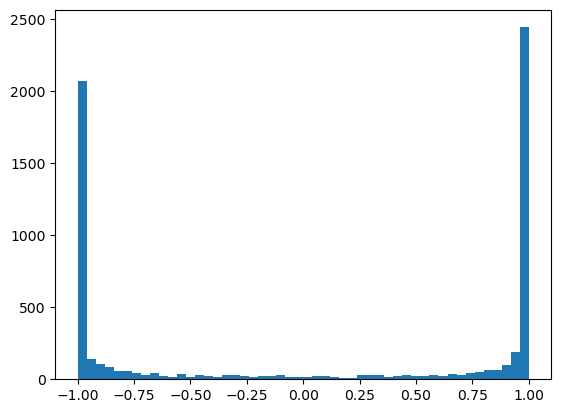

In [123]:
# h.shape
# torch.Size([32, 200])  # 200 neurons for each of the 32 examples (3 letter context) in that batch

# lets plot a histogram of h
plt.hist(h.view(-1).tolist(), 50);  # semicolon supresses some unneeded text along with output from displaying
# most values are -1 or 1

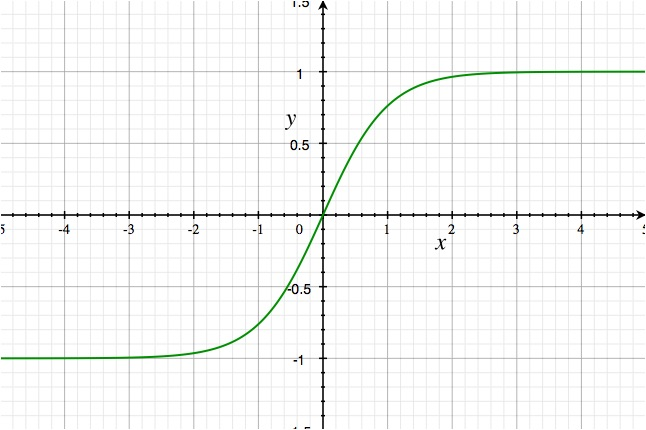

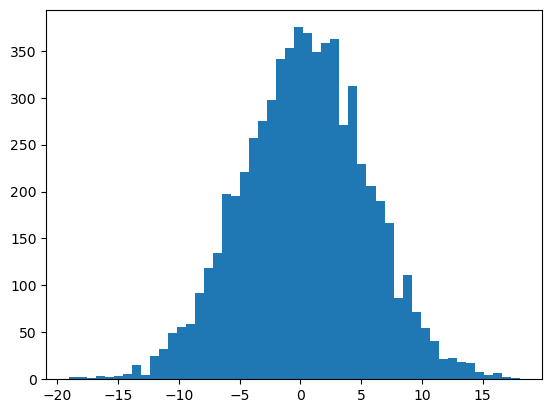

In [110]:
# to see why that is the case, we need to see the h pre-activations
plt.hist(hpreact.view(-1).tolist(), 50);

# as we can see, a large number of values are above 2 or below -2, so when they are put through tanh,
# they get squashed to 1 and -1

In [ ]:
# to understand why this is bad, let's look at some code from micrograd

# the tanh function from our 'Value' class
# def tanh(self):
#         x = self.data
#         t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
#         out = Value(t, (self, ), 'tanh')

#         def _backward():
#             self.grad += (1 - t**2) * out.grad
#         out._backward = _backward
        
#         return out

# now, if we have large values (in both -ve and +ve), and apply tanh to them, we will get t = 1 or t = -1 on applying tanh
# now when we calculate backward() on them, here's what will happen
# self.grad += (1 - t**2) * out.grad
# t = 1 or t = -1
# therefore, our self.grad will become, no matter what out.grad is,
# self.grad += (1 - 1) * out.grad ==> self.grad += 0 * out.grad ==> self.grad += 0
# we are 'killing' the gradient and any further gradients along that line, all will be 0
# so we are stopping backprop through the tanh units for these values
# this is kind of like a permanent brain damage in the mind of the network
# this happens in activation functions which have 'flat tails', like tanh, ReLu, sigmoid
# some other activation functions will not suffer from this issue as much, because they don't have a flat tail, like leaky ReLu, ELU, maxout

# if our t = 0
# self.grad += (1 - 0) * out.grad ==> self.grad += 1 * out.grad ==> self.grad += out.grad
# so the tanh unit is sort of 'inactive', and our gradient just passes through
# but note that this isn't a BAD thing like our previous situation with the 1 or -1

# but what this tells us about the tanh in general by seeing this eqn: (1 - t**2) <--- this is the derivative of tanh
# the gradient flowing through tanh can only ever decrease
# and the amount that it decreases is proportional to a square function

# to solve this issue, we will multiply the W1 and b1 by a very small number, for example, 0.01
# as they are the ones causing hpreact to have large values, and thus the problem in h
# hpreact = embcat @ W1 + b1

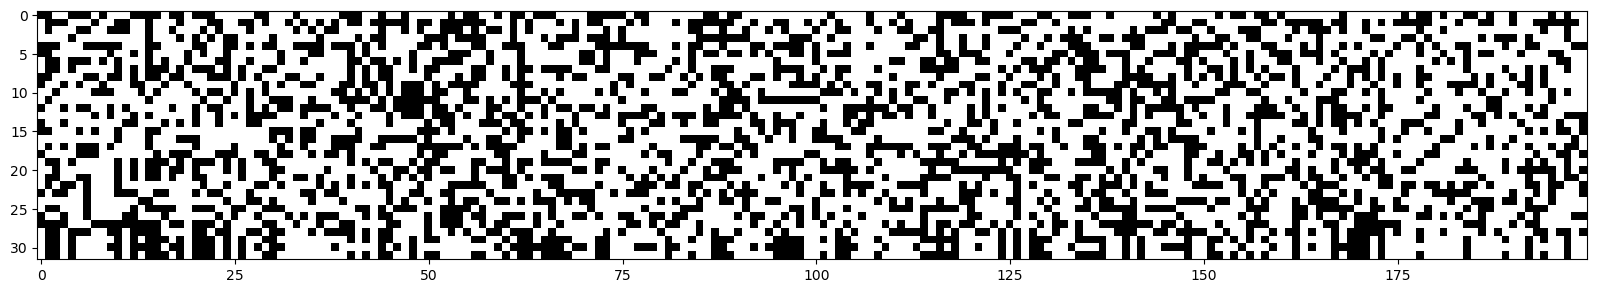

In [112]:
# we are trying to see how often values in h are in this 'bad' region of -1 or 1
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# h.abs() > 0.99  --> boolean ---> white if true, black if false

# turns out, quite often for now
# a lot of it is white
# so in all these cases, the backward gradient would get 'destroyed'

# it would be really bad, if we had for any one of these 200 neurons, an entire dead column
# this would be called a dead neuron, it will never learn
# fortunately we don't have any here like that

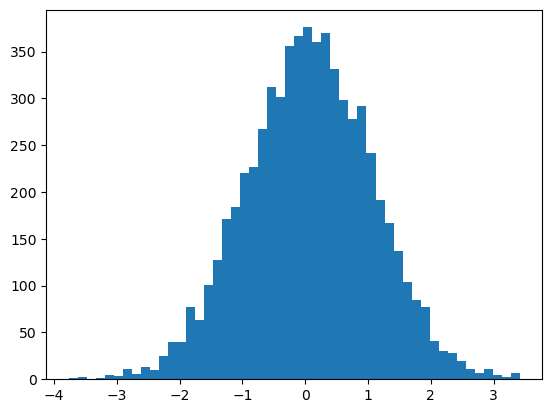

In [134]:
plt.hist(hpreact.view(-1).tolist(), 50);

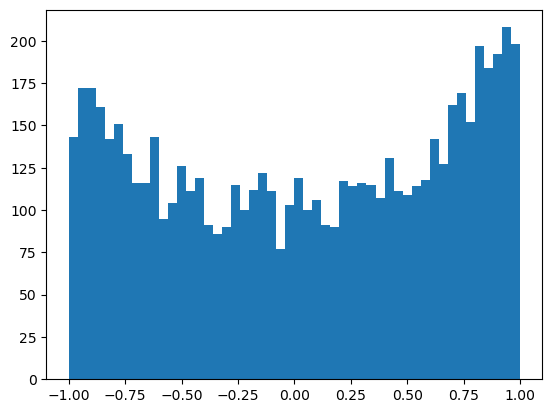

In [133]:
plt.hist(h.view(-1).tolist(), 50);

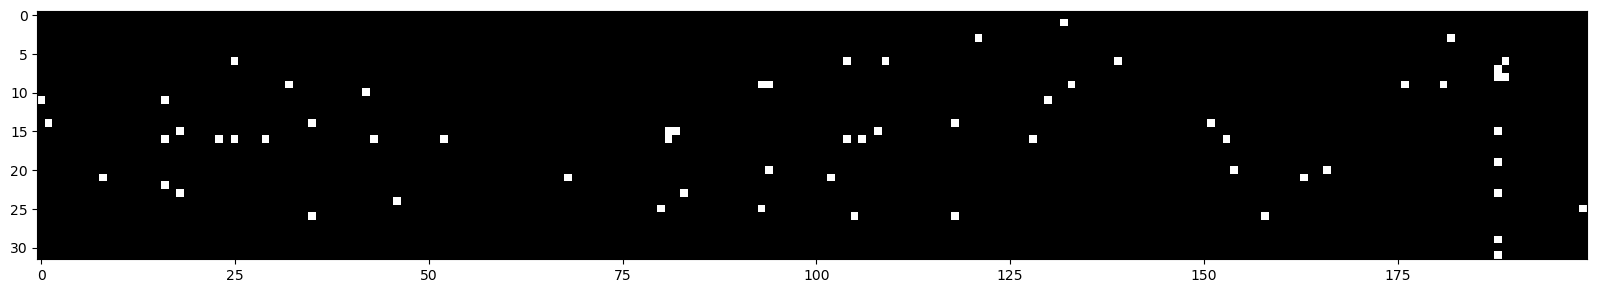

In [135]:
# we are trying to see how often values in h are in this 'bad' region of -1 or 1
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# h.abs() > 0.99  --> boolean ---> white if true, black if false

tensor(0.0026) tensor(0.9928)
tensor(-0.0002) tensor(0.9684)


(array([2.23378228e-05, 0.00000000e+00, 4.46756455e-05, 0.00000000e+00,
        1.56364759e-04, 2.23378228e-04, 2.68053873e-04, 8.04161619e-04,
        1.11689114e-03, 1.89871493e-03, 3.06028172e-03, 4.60159149e-03,
        7.48317062e-03, 1.11018979e-02, 1.94339058e-02, 3.12952897e-02,
        4.94112639e-02, 6.92919262e-02, 1.01882810e-01, 1.49194318e-01,
        2.02782755e-01, 2.62000323e-01, 3.31135885e-01, 3.92922302e-01,
        4.33621815e-01, 4.50397520e-01, 4.26942806e-01, 3.75543476e-01,
        3.14159139e-01, 2.44018376e-01, 1.84912497e-01, 1.28933913e-01,
        9.31040453e-02, 6.13843369e-02, 4.28886197e-02, 2.69394142e-02,
        1.72224613e-02, 1.06104658e-02, 6.54498207e-03, 4.13249721e-03,
        2.25612010e-03, 1.76468800e-03, 8.04161619e-04, 5.13769923e-04,
        2.90391696e-04, 2.01040405e-04, 8.93512910e-05, 2.23378228e-05,
        4.46756455e-05, 8.93512910e-05]),
 array([-5.67410278, -5.45026718, -5.22643158, -5.00259598, -4.77876038,
        -4.55492477, 

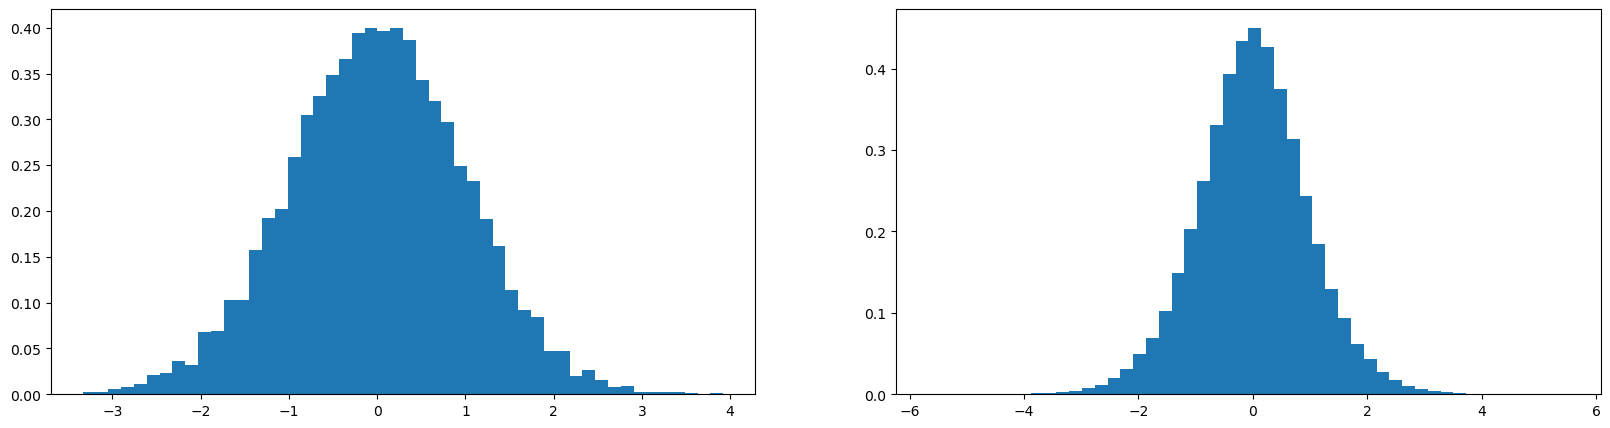

In [20]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

# when we multiply w with a large number, our standard deviation increases
# standard deviation is the measure of the spread of our data
# we prefer to preserve this spread that x has and keep it as similar to it as possible, when we get y by multiplying x and w
# if we multiply even without a large number multiplied to w, our S.D. increases
# if we multiply it by a number smaller than 1, we make our standard deviation smaller
# mean remains about the same in any case
# we want to exactly preserve x's S.D. to be ~1
# so the way to do this (derived mathematically), is to divide w by the square root of number of inputs (called fan in) to w
# eg: w = torch.randn(10, 200) / 10**0.5

# to be exactly accurate and for different activation functions
# there is a function in pytorch called Kaiming init based on this paper https://arxiv.org/abs/1502.01852
# torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
# we want to set the S.D. to be: gain / sqrt(fan_in)  ----> based on experimental outcomes from the research paper
# where gain is a constant experimentally discovered from the paper
# the gain for each activation function is different --> https://pytorch.org/docs/stable/nn.init.html
# gain for tanh is 5/3

In [33]:
torch.randn(10000).std()
# tensor(0.9995)
# the S.D. on intialization is ~1

(torch.randn(10000) * 0.2).std()
# if you multiply it by any number, that effectively becomes its S.D.  (since 1 * n = n)

# for tanh, in our case
(5/3) / (layer_1_input**0.5)
# this is what we want our S.D. to be

0.3042903097250923

In [ ]:
# we want our hpreact to be unit gaussian, i.e. gaussian between 1 and -1, at initialization
# this is a differentiable operation, so it can be backpropagated through
# batchnorm paper --> https://arxiv.org/abs/1502.03167
# if the values in our hpreact are too small, then tanh is kind of inactive
# if they are very large numbers, then the tanh is too saturated and the gradient doesn't flow

# batch norm removes the need to carefully initialize, like we did prior with kaiming init. we don't have to do things separately for different activation functions
# bngain and bnbias turn our batch norm to a learnable feature which can be learned through backprop

# acts as regularizer too
# as the bngain and bnbias is affected by the examples that came before in that batch
# due to batch normalization, inputs in a batch are mathematically coupled because the normalization is done across the batch
# prevents model from 'overfitting'

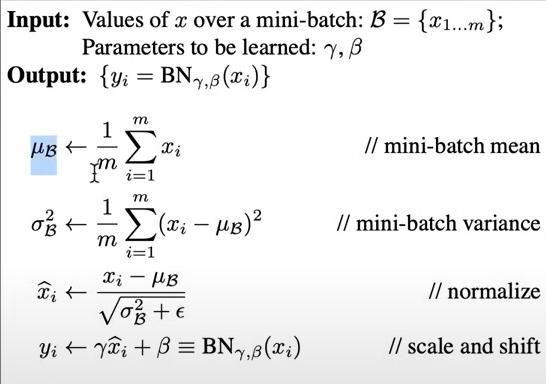

In [43]:
hpreact.shape   # (32, 200) ---> 32 examples, 200 neurons

hpreact.mean(0, keepdim=True)  # by 0 here we mean we want to calculate mean across the 0th dimension, i.e. along the columns. so mean of each column
# hpreact.mean(0, keepdim=True).shape ---> torch.Size([1, 200])

hpreact.std(0, keepdim=True)  # S.D. ---> has same dimensions as the mean

# S.D. = sqrt(variance) ---> Variance = (S.D.)^2
# to normalize, we subtract each value and the mean and divide it by the S.D., as in the formula
# (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

tensor([[1.5754, 1.3254, 1.5610, 1.4098, 1.6534, 1.2083, 0.9523, 1.1277, 1.9093,
         1.3163, 1.2751, 1.1636, 1.1184, 1.2403, 0.9120, 1.2187, 1.9744, 1.2237,
         1.8974, 1.2805, 1.2232, 1.4200, 1.5374, 1.6672, 1.1480, 1.5804, 1.1898,
         1.2942, 1.8189, 1.6032, 1.3553, 1.3369, 1.6952, 1.5864, 1.5168, 1.5035,
         1.0359, 1.9976, 1.3965, 1.7787, 1.0727, 1.3621, 1.6309, 2.0599, 1.1662,
         1.2218, 1.5208, 1.5761, 0.8647, 1.2208, 0.9464, 0.9392, 1.2892, 0.9674,
         1.3067, 1.5019, 0.9808, 1.8787, 1.6687, 1.4628, 1.1963, 1.3688, 0.8030,
         1.2942, 1.4992, 1.3359, 1.3997, 1.0738, 1.6988, 1.8295, 1.1145, 1.5140,
         1.1073, 1.1720, 1.0499, 1.4159, 1.0021, 1.7107, 1.3186, 1.3349, 1.8360,
         1.5398, 1.6573, 1.8745, 1.4010, 1.3539, 1.1694, 1.0472, 1.1543, 1.1884,
         1.3937, 1.4828, 1.5281, 2.3096, 2.1635, 1.4064, 1.5561, 1.0843, 1.1285,
         1.2335, 1.2424, 1.2700, 1.9116, 1.1724, 1.4420, 1.5626, 1.4210, 1.2810,
         1.7997, 1.6398, 1.1

In [ ]:
# we train our nn on batches
# but when we deploy our model, we want to be able to put in one input and get an output, not have to input a whole batch
# to solve this, we have a step after training that calulates and sets the batchnorm a single time over the training set

In [ ]:
# calibrate the batch norm at the end of training

# but actually, no one does this separately, this is done simultaneously as the model trains
# this was just to explain the concept

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
# also whenever we have batch normalization on a layer, we are better off not using bias on it
# adding bias after multiplying weights will be redundant here because

# whatever bias we add here in this line, it will get subtracted in the last line of this piece of code through bnmeani
# hpreact = embcat @ W1 + b1  # hidden layer pre-activation

# bnmeani = hpreact.mean(0, keepdim=True)
# bnstdi = hpreact.std(0, keepdim=True)
# hpreact = (bngain * (hpreact - bnmeani) / bnstdi) + bnbias  # batch normalization layer

layer 1 (      Tanh): mean -0.01, std 0.79, saturated: 28.16%
layer 3 (      Tanh): mean -0.03, std 0.77, saturated: 21.19%
layer 5 (      Tanh): mean -0.01, std 0.77, saturated: 20.28%
layer 7 (      Tanh): mean -0.02, std 0.76, saturated: 16.84%
layer 9 (      Tanh): mean -0.09, std 0.72, saturated: 15.84%


Text(0.5, 1.0, 'activation distribution')

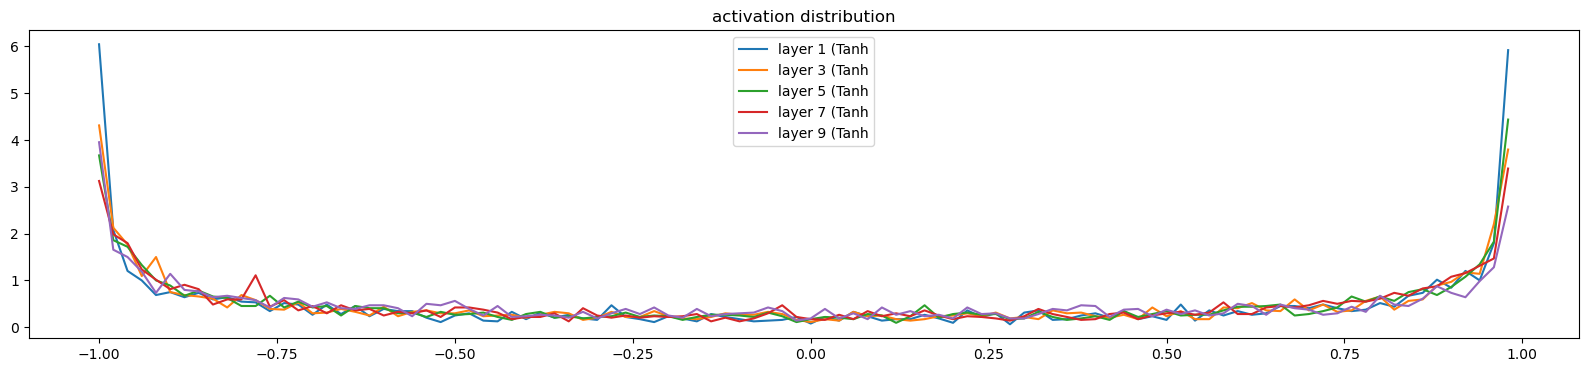

In [70]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()> 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True) 
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (Tanh): mean -0.00, std 0.00
layer 3 (Tanh): mean -0.00, std 0.00
layer 5 (Tanh): mean -0.00, std 0.00
layer 7 (Tanh): mean 0.00, std 0.00
layer 9 (Tanh): mean 0.00, std 0.00


Text(0.5, 1.0, 'gradient distribution')

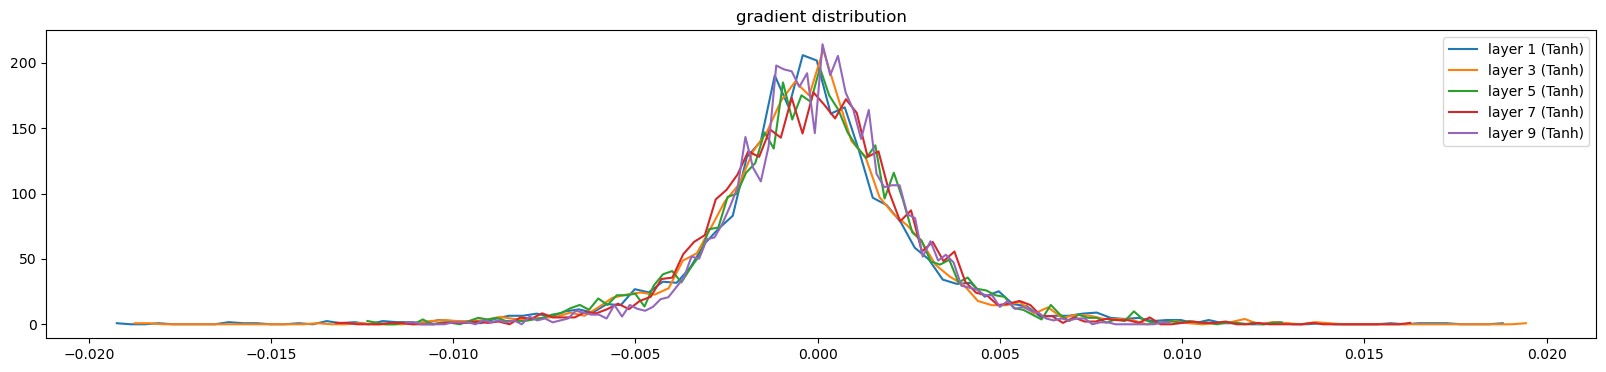

In [71]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad  # Assuming you want to plot the gradient
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():.2f}, std {t.std():.2f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight (27, 10) | mean 0.000021 | std 1.034911e-02 | grad:data ratio 2.024325e-03
weight (30, 100) | mean -0.000155 | std 8.155161e-03 | grad:data ratio -1.900454e-02
weight (100, 100) | mean -0.000043 | std 6.876219e-03 | grad:data ratio -6.256902e-03
weight (100, 100) | mean 0.000008 | std 5.973164e-03 | grad:data ratio 1.316174e-03
weight (100, 100) | mean 0.000075 | std 5.911645e-03 | grad:data ratio 1.269770e-02
weight (100, 100) | mean -0.000061 | std 5.366539e-03 | grad:data ratio -1.144730e-02
weight (100, 27) | mean 0.000000 | std 2.315959e-02 | grad:data ratio 2.859610e-09


Text(0.5, 1.0, 'Weights Gradient Distribution')

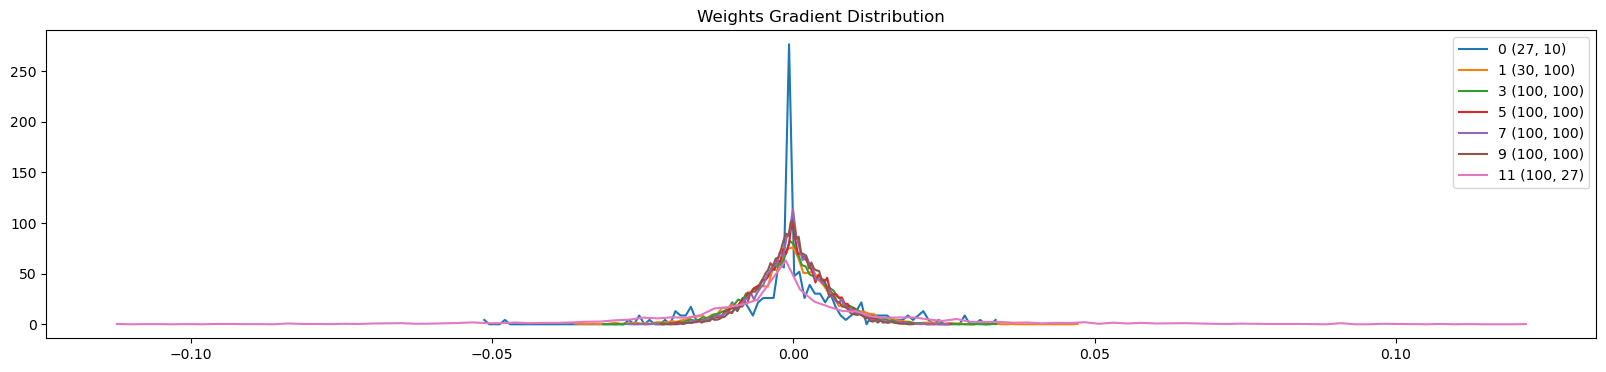

In [72]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:  # Check if the parameter is a weight matrix
        print(f'weight {tuple(p.shape)} | mean {t.mean():.6f} | std {t.std():.6e} | grad:data ratio {t.mean() / (t.std() + 1e-10):.6e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution')

Text(0.5, 1.0, 'Parameter Ratios Over Iterations')

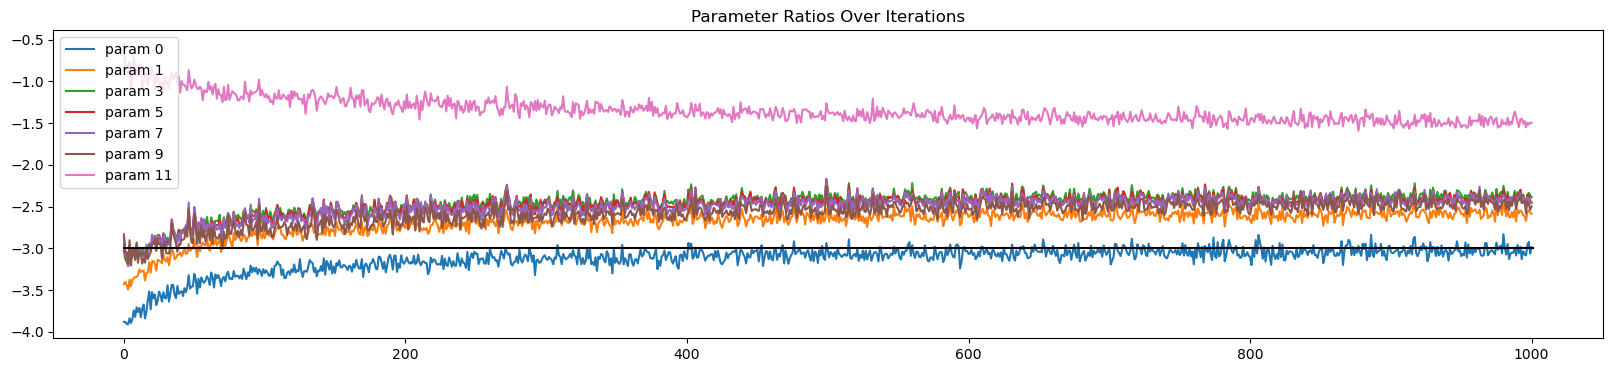

In [74]:
plt.figure(figsize=(20, 4)) 
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:  # Check if the parameter is a 2-dimensional tensor
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')  # these ratios should be ~1e-3, indicate on plot  # the updates should ideally be ~1/1000 of the data value
plt.legend(legends)
plt.title('Parameter Ratios Over Iterations')